In [113]:
import os
import cv2
import numpy as np
from PIL import Image
import skimage.io as io
import matplotlib.pyplot as plt
import json
import random
import shutil

import torch
import torchvision
import torchvision.transforms as T

import pycocotools.coco as coco
from pycocotools.coco import COCO

CLASSES = ['N/A', 'rebar', 'crack', 'spall']

def create_json(imgfile_list):
    img_idx = 0
    ann_idx = 0
    img_cocolist = []
    ann_cocolist = []
    
    for imgfile in imgfile_list:
#         print(f'processing {imgfile}')
        name_noext = os.path.splitext(os.path.basename(imgfile))[0]
        img = cv2.imread(imgfile)
        i_dict = {}
        i_dict['id'] = img_idx
        i_dict['width'] = img.shape[1]
        i_dict['height'] = img.shape[0]
        i_dict['file_name'] = imgfile #os.path.basename(imgfile)
        i_dict['coco_url'] = imgfile
        
        
        ## get corresponding mask
        mask_dir = os.path.join(project_folder, 'masks')
#         print(f'maskdir {mask_dir}')
        a_catid = None
        maskfile = None
        if os.path.exists(os.path.join(mask_dir, f'{name_noext}rebar.jpg')):
            maskfile = os.path.join(mask_dir, f'{name_noext}rebar.jpg')
            a_catid = 1
        elif os.path.exists(os.path.join(mask_dir, f'{name_noext}crack.jpg')):
            maskfile = os.path.join(mask_dir, f'{name_noext}crack.jpg')
            a_catid = 2
        elif os.path.exists(os.path.join(mask_dir, f'{name_noext}spall.jpg')):
            maskfile = os.path.join(mask_dir, f'{name_noext}spall.jpg')
            a_catid = 3
            
        if a_catid is None:
            print(f'cannot find mask for {imgfile}!')
            continue
            
#         print(f'maskfile is {maskfile}')
        mask_img = cv2.imread(maskfile, cv2.IMREAD_GRAYSCALE).astype(np.uint8)
        ## get contours and create annotation
        ctrs, _ = cv2.findContours(mask_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for ctr in ctrs:
            a_dict = {}
            x,y,w,h = cv2.boundingRect(ctr)
            area = cv2.contourArea(ctr)
            if area == 0:
                continue
            a_dict['id'] = ann_idx
            a_dict['image_id'] = img_idx
            a_dict['category_id'] = a_catid
#             a_dict['segmentation'] = ctr
            a_dict['area'] = area
            a_dict['bbox'] = [x,y,w,h]
            a_dict['iscrowd'] = 0
            a_dict['segmentation'] = []
            ann_cocolist.append(a_dict)
            ann_idx += 1
        
        img_cocolist.append(i_dict)
        img_idx += 1
    
    
    cat_cocolist = [{'id':1, 'name': 'rebar', 'supercategory':''},
                    {'id':2, 'name': 'crack', 'supercategory':''},
                    {'id':3, 'name': 'spall', 'supercategory':''}]
    
    
    all_cocolist = {'categories':cat_cocolist, 
                    'images': img_cocolist, 
                    'annotations': ann_cocolist}
    return all_cocolist

In [120]:
project_folder = '/media/App/tsai/capstone/'
img_list = []
img_folder = os.path.join(project_folder, 'images')
for imgfile in os.listdir(img_folder):
    img_list.append(os.path.join(img_folder, imgfile))
    
    
total = len(img_list)
train_len = round(0.6*total)
val_len = round(0.8*total)
random.shuffle(img_list)
train_list = img_list[:train_len]
val_list = img_list[train_len:val_len]
test_list = img_list[val_len:]

## copy train images to train folder
for ti in train_list:
    shutil.copy2(ti, os.path.join(project_folder, 'train'))
for vi in val_list:
    shutil.copy2(vi, os.path.join(project_folder, 'val'))

In [121]:
# len(train_list), len(val_list), len(test_list)
## get train and val list from newly copied directories
train_list = []
train_folder = os.path.join(project_folder, 'train')
for imgfile in os.listdir(train_folder):
    train_list.append(os.path.join(train_folder, imgfile))
    
    
val_list = []
val_folder = os.path.join(project_folder, 'val')
for imgfile in os.listdir(val_folder):
    val_list.append(os.path.join(val_folder, imgfile))

In [122]:
# s = json.dumps(cocolist)
annfile = os.path.join(project_folder, 'annotations', 'custom_train.json')
cocolist = create_json(train_list)
with open(annfile, 'w') as f:
    json.dump(cocolist, f)
    

annfile = os.path.join(project_folder, 'annotations', 'custom_val.json')
cocolist = create_json(val_list)
with open(annfile, 'w') as f:
    json.dump(cocolist, f)
    


# DEBUG

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
COCO categories: 
rebar crack spall
showing validation file /media/App/tsai/capstone/val/IMG_7311.jpg


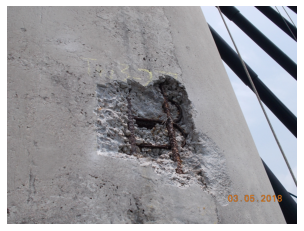

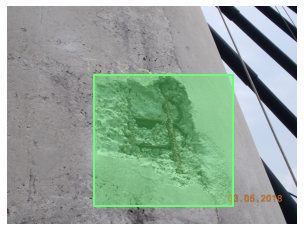

In [123]:
## show a random file
coco = COCO(annfile)

cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print(f'COCO categories: \n{" ".join(nms)}')

# get all images containing given categories, select one at random
catIds = coco.getCatIds(catNms=['rebar', 'crack', 'spall']);
imgIds = coco.getImgIds(catIds=catIds );
imgIds = coco.getImgIds(imgIds = [0])
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
print(f'showing validation file {img["file_name"]}')
I = io.imread(img['file_name'])
plt.axis('off')
plt.imshow(I)
plt.show()

plt.imshow(I); plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns, draw_bbox = True)

In [95]:
anns[0]

{'id': 0,
 'image_id': 0,
 'category_id': 2,
 'area': 542.5,
 'bbox': [124, 0, 143, 62],
 'iscrowd': 0,
 'segmentation': []}